# ACIT5900: Master Thesis
### *Data Preprocessing and Cleaning*

>-------------------------------------------
> *Spring 2025*

>--------------------------------------------

<a id="top"></a>
1. [**Data Preprocessing**](#processing)<br>
    1.1 [**Read and Inspect Data**](#read) <br>
    1.2 [**Handle Missing Values**](#missing) <br>
    1.3 [**Extract Abstract**](#abstract) <br>
2. [**Data Cleaning**](#cleaning)<br>
    2.1 [**Cleaning of Text Content**](#text) <br>
    2.2 [**Cleaning of Author Column**](#author) <br>



In [ ]:
!pip install networkx nameparser

In [ ]:
# import modules needed
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from nameparser import HumanName
from collections import defaultdict

In [3]:
# read data
df = pd.read_csv('df_combined.csv')
df.head()

,title,authors,year_published,number,volume,journal,type,content,doi,file
0,Contrastive autoencoder for anomaly detection ...,Hao Zhou and Ke Yu and Xuan Zhang and Guanlin ...,2022,NaN,610,Information Sciences,article,Contrastive autoencoder for anomaly detection ...,https://doi.org/10.1016/j.ins.2022.07.179,doc16
1,Detection of abnormality in wireless capsule e...,Samir Jain and Ayan Seal and Aparajita Ojha an...,2020,NaN,127,Computers in Biology and Medicine,article,Computers in Biology and Medicine 127 (2020) 1...,https://doi.org/10.1016/j.compbiomed.2020.104094,doc17
2,Single image dehazing using a new color channel,Geet Sahu and Ayan Seal and Ondrej Krejcar and...,2021,NaN,74,Journal of Visual Communication and Image Repr...,article,J. Vis. Commun. Image R. 74 (2021) 103008\nAva...,https://doi.org/10.1016/j.jvcir.2020.103008,doc15
3,Estimating Tukey depth using incremental quant...,Hugo L. Hammer and Anis Yazidi and Håvard Rue,2022,NaN,122,Pattern Recognition,article,Pattern Recognition 122 (2022) 108339 \nConten...,https://doi.org/10.1016/j.patcog.2021.108339,doc29
4,Advanced Passive Operating System Fingerprinti...,"Hagos, Desta Haileselassie and Løland, Martin ...",2020,NaN,NaN,NaN,inproceedings,Advanced Passive Operating System Fingerprinti...,10.1109/ICCCN49398.2020.9209694,doc28


In [4]:
df = df.fillna('missing')
df.head()

,title,authors,year_published,number,volume,journal,type,content,doi,file
0,Contrastive autoencoder for anomaly detection ...,Hao Zhou and Ke Yu and Xuan Zhang and Guanlin ...,2022,missing,610,Information Sciences,article,Contrastive autoencoder for anomaly detection ...,https://doi.org/10.1016/j.ins.2022.07.179,doc16
1,Detection of abnormality in wireless capsule e...,Samir Jain and Ayan Seal and Aparajita Ojha an...,2020,missing,127,Computers in Biology and Medicine,article,Computers in Biology and Medicine 127 (2020) 1...,https://doi.org/10.1016/j.compbiomed.2020.104094,doc17
2,Single image dehazing using a new color channel,Geet Sahu and Ayan Seal and Ondrej Krejcar and...,2021,missing,74,Journal of Visual Communication and Image Repr...,article,J. Vis. Commun. Image R. 74 (2021) 103008\nAva...,https://doi.org/10.1016/j.jvcir.2020.103008,doc15
3,Estimating Tukey depth using incremental quant...,Hugo L. Hammer and Anis Yazidi and Håvard Rue,2022,missing,122,Pattern Recognition,article,Pattern Recognition 122 (2022) 108339 \nConten...,https://doi.org/10.1016/j.patcog.2021.108339,doc29
4,Advanced Passive Operating System Fingerprinti...,"Hagos, Desta Haileselassie and Løland, Martin ...",2020,missing,missing,missing,inproceedings,Advanced Passive Operating System Fingerprinti...,10.1109/ICCCN49398.2020.9209694,doc28


In [ ]:
df['content'].str.contains(r'(?i)\babstract\b', regex=True)

0     False
1     False
2     False
3     False
4      True
5      True
6      True
7      True
8     False
9      True
10     True
11    False
12    False
13    False
14    False
15     True
16     True
17    False
18    False
19    False
20    False
21    False
22     True
23     True
24    False
25    False
26     True
27    False
28     True
29    False
30     True
31     True
32     True
33     True
34    False
35     True
36    False
Name: content, dtype: bool

In [6]:
def extract_abstract(text):
    '''
    Extract abstract from articles.
    '''
    match = re.search(r'(?i)\babstract\b(.*?)(?=\b(introduction|keywords|1\.|I\.)\b|$)', text, re.DOTALL)
    return match.group(1).strip() if match else None

In [7]:
# keep only documents that have an abstract
df = df[df['content'].str.contains(r'(?i)\babstract\b', regex=True)].copy()

# extract the abstract
df['abstract'] = df['content'].apply(extract_abstract)

# remove the abstract from the content column
df['content'] = df.apply(lambda row: row['content'].replace(row['abstract'], '', 1) if row['abstract'] else row['content'], axis=1)
df

,title,authors,year_published,number,volume,journal,type,content,doi,file,abstract
4,Advanced Passive Operating System Fingerprinti...,"Hagos, Desta Haileselassie and Løland, Martin ...",2020,missing,missing,missing,inproceedings,Advanced Passive Operating System Fingerprinti...,10.1109/ICCCN49398.2020.9209694,doc28,"—Securing and managing large, complex enterpri..."
5,Artificial intelligence in the fertility clini...,"Riegler, M A and Stensen, M H and Witczak, O a...",2021,9.0,36,Human Reproduction,article,.................................................,10.1093/humrep/deab168,doc14,": In recent years, the amount of data produced..."
6,EvoDynamic: A Framework for the Evolution of G...,"Pontes-Filho, Sidney\nand Lind, Pedro\nand Yaz...",2020,missing,missing,missing,inproceedings,EvoDynamic: a framework for the evolution of\n...,missing,doc10,. Dynamical systems possess a computational ca...
7,A general representation of dynamical systems ...,Sidney Pontes{-}Filho and\nAnis Yazidi and\nJi...,2019,missing,abs/1907.01856,CoRR,article,A general representation of dynamical systems ...,missing,doc11,—Dynamical systems are capable of performing c...
9,Exploring Multilingual Word Embedding Alignmen...,"Aaby, Pernille\nand Biermann, Daniel\nand Yazi...",2023,missing,missing,missing,inproceedings,"\n \n \n \nAccepted manuscript \nAaby, P., Bi...",missing,doc12,". Contextual language models, such as transfor..."
10,A Deep Learning-Based Tool for Automatic Brain...,"Pontes-Filho, Sidney\nand Dahl, Annelene Gulde...",2022,missing,missing,missing,inproceedings,A deep learning based tool for automatic brain...,missing,doc9,—Removing skull artifacts from functional magn...
15,Genetic Algorithms For Tightening Security,"Palumbo, Fabrizio and Buji, Adam and Yazidi, A...",2022,missing,missing,missing,inproceedings,Genetic Algorithms For Tightening Security\n1s...,10.23919/WMNC56391.2022.9954297,doc7,—Proper conﬁguration of operating systems and ...
16,How (not to) Run an AI Project in Investigativ...,"M. Fridman, R. Krøvel and F. Palumbo",2023,0.0,0,Journalism Practice,article,Journalism Practice\nISSN: (Print) (Online) Jo...,10.1080/17512786.2023.2253797,doc3,Data journalists are increasingly reliant on a...
22,A New Adaptive Mixture Distance-Based Improved...,"Sharma, Krishna Kumar and Seal, Ayan and Yazid...",2022,missing,71,IEEE Transactions on Instrumentation and Measu...,article,IEEE TRANSACTIONS ON INSTRUMENTATION AND MEASU...,10.1109/TIM.2022.3216366,doc22,—With the rapid development of sensors and mec...
23,A sensitivity analysis of cellular automata an...,"Tom Eivind Glover, Ruben Jahren, Francesco Mar...",2025,1.0,40,"International Journal of Parallel, Emergent an...",article,"International Journal of Parallel, Emergent an...",10.1080/17445760.2024.2396334,doc34,Elementary Cellular Automata (ECA) are well-st...


In [8]:
df[['authors']]

,authors
4,"Hagos, Desta Haileselassie and Løland, Martin ..."
5,"Riegler, M A and Stensen, M H and Witczak, O a..."
6,"Pontes-Filho, Sidney\nand Lind, Pedro\nand Yaz..."
7,Sidney Pontes{-}Filho and\nAnis Yazidi and\nJi...
9,"Aaby, Pernille\nand Biermann, Daniel\nand Yazi..."
10,"Pontes-Filho, Sidney\nand Dahl, Annelene Gulde..."
15,"Palumbo, Fabrizio and Buji, Adam and Yazidi, A..."
16,"M. Fridman, R. Krøvel and F. Palumbo"
22,"Sharma, Krishna Kumar and Seal, Ayan and Yazid..."
23,"Tom Eivind Glover, Ruben Jahren, Francesco Mar..."


In [9]:
df['authors_list'] = df['authors'].apply(lambda x: x.split(" and "))
df

,title,authors,year_published,number,volume,journal,type,content,doi,file,abstract,authors_list
4,Advanced Passive Operating System Fingerprinti...,"Hagos, Desta Haileselassie and Løland, Martin ...",2020,missing,missing,missing,inproceedings,Advanced Passive Operating System Fingerprinti...,10.1109/ICCCN49398.2020.9209694,doc28,"—Securing and managing large, complex enterpri...","[Hagos, Desta Haileselassie, Løland, Martin, Y..."
5,Artificial intelligence in the fertility clini...,"Riegler, M A and Stensen, M H and Witczak, O a...",2021,9.0,36,Human Reproduction,article,.................................................,10.1093/humrep/deab168,doc14,": In recent years, the amount of data produced...","[Riegler, M A, Stensen, M H, Witczak, O, Ander..."
6,EvoDynamic: A Framework for the Evolution of G...,"Pontes-Filho, Sidney\nand Lind, Pedro\nand Yaz...",2020,missing,missing,missing,inproceedings,EvoDynamic: a framework for the evolution of\n...,missing,doc10,. Dynamical systems possess a computational ca...,"[Pontes-Filho, Sidney\nand Lind, Pedro\nand Ya..."
7,A general representation of dynamical systems ...,Sidney Pontes{-}Filho and\nAnis Yazidi and\nJi...,2019,missing,abs/1907.01856,CoRR,article,A general representation of dynamical systems ...,missing,doc11,—Dynamical systems are capable of performing c...,[Sidney Pontes{-}Filho and\nAnis Yazidi and\nJ...
9,Exploring Multilingual Word Embedding Alignmen...,"Aaby, Pernille\nand Biermann, Daniel\nand Yazi...",2023,missing,missing,missing,inproceedings,"\n \n \n \nAccepted manuscript \nAaby, P., Bi...",missing,doc12,". Contextual language models, such as transfor...","[Aaby, Pernille\nand Biermann, Daniel\nand Yaz..."
10,A Deep Learning-Based Tool for Automatic Brain...,"Pontes-Filho, Sidney\nand Dahl, Annelene Gulde...",2022,missing,missing,missing,inproceedings,A deep learning based tool for automatic brain...,missing,doc9,—Removing skull artifacts from functional magn...,"[Pontes-Filho, Sidney\nand Dahl, Annelene Guld..."
15,Genetic Algorithms For Tightening Security,"Palumbo, Fabrizio and Buji, Adam and Yazidi, A...",2022,missing,missing,missing,inproceedings,Genetic Algorithms For Tightening Security\n1s...,10.23919/WMNC56391.2022.9954297,doc7,—Proper conﬁguration of operating systems and ...,"[Palumbo, Fabrizio, Buji, Adam, Yazidi, Anis, ..."
16,How (not to) Run an AI Project in Investigativ...,"M. Fridman, R. Krøvel and F. Palumbo",2023,0.0,0,Journalism Practice,article,Journalism Practice\nISSN: (Print) (Online) Jo...,10.1080/17512786.2023.2253797,doc3,Data journalists are increasingly reliant on a...,"[M. Fridman, R. Krøvel, F. Palumbo]"
22,A New Adaptive Mixture Distance-Based Improved...,"Sharma, Krishna Kumar and Seal, Ayan and Yazid...",2022,missing,71,IEEE Transactions on Instrumentation and Measu...,article,IEEE TRANSACTIONS ON INSTRUMENTATION AND MEASU...,10.1109/TIM.2022.3216366,doc22,—With the rapid development of sensors and mec...,"[Sharma, Krishna Kumar, Seal, Ayan, Yazidi, An..."
23,A sensitivity analysis of cellular automata an...,"Tom Eivind Glover, Ruben Jahren, Francesco Mar...",2025,1.0,40,"International Journal of Parallel, Emergent an...",article,"International Journal of Parallel, Emergent an...",10.1080/17445760.2024.2396334,doc34,Elementary Cellular Automata (ECA) are well-st...,"[Tom Eivind Glover, Ruben Jahren, Francesco Ma..."


In [10]:
df[['authors_list']]

,authors_list
4,"[Hagos, Desta Haileselassie, Løland, Martin, Y..."
5,"[Riegler, M A, Stensen, M H, Witczak, O, Ander..."
6,"[Pontes-Filho, Sidney\nand Lind, Pedro\nand Ya..."
7,[Sidney Pontes{-}Filho and\nAnis Yazidi and\nJ...
9,"[Aaby, Pernille\nand Biermann, Daniel\nand Yaz..."
10,"[Pontes-Filho, Sidney\nand Dahl, Annelene Guld..."
15,"[Palumbo, Fabrizio, Buji, Adam, Yazidi, Anis, ..."
16,"[M. Fridman, R. Krøvel, F. Palumbo]"
22,"[Sharma, Krishna Kumar, Seal, Ayan, Yazidi, An..."
23,"[Tom Eivind Glover, Ruben Jahren, Francesco Ma..."


/var/folders/32/blww0r_s507dkfvsqxqlglzw0000gn/T/ipykernel_92084/3273057317.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


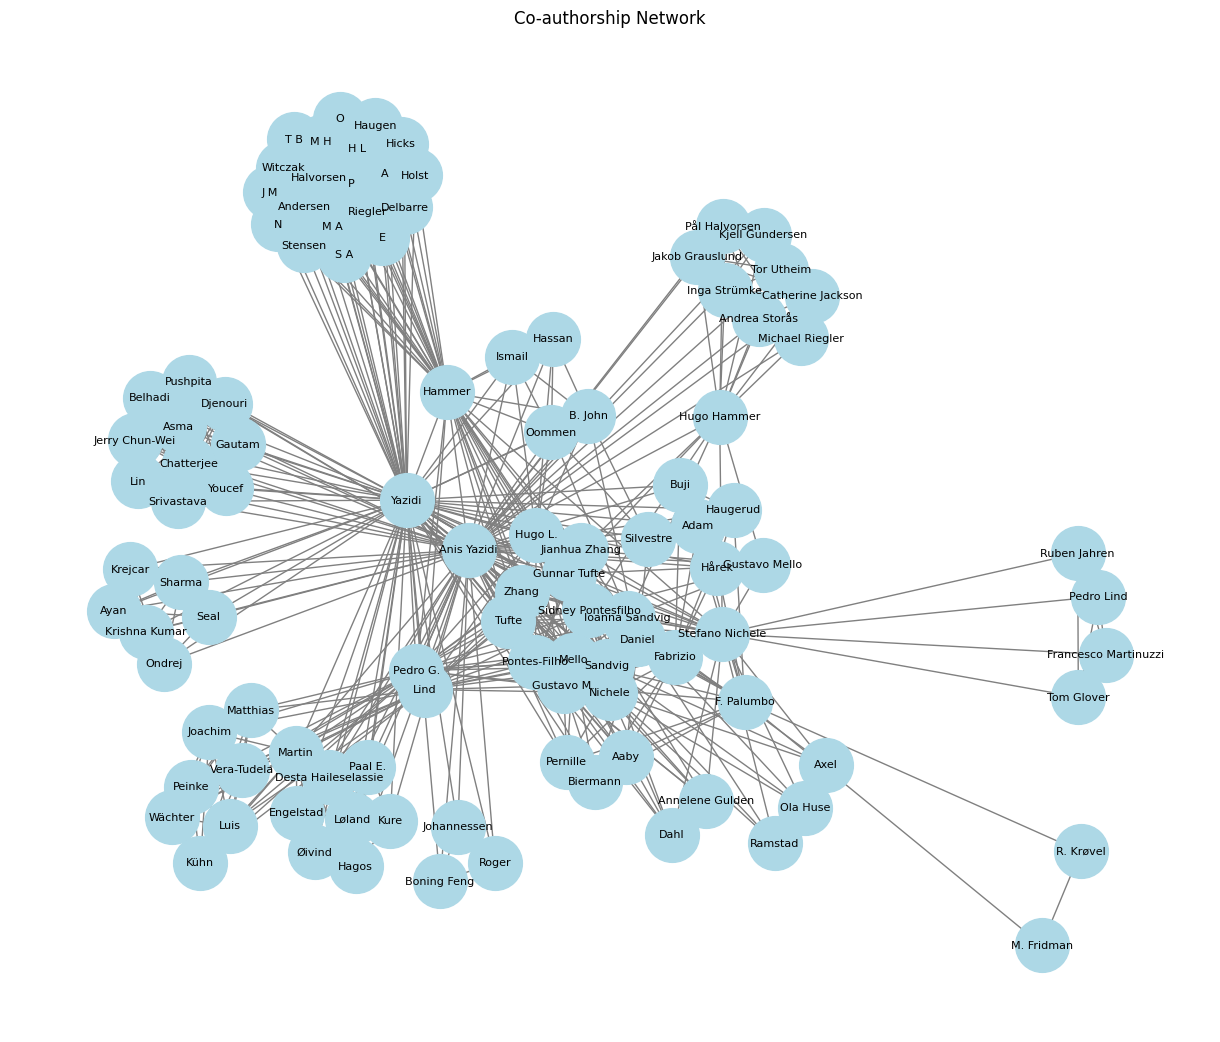

In [11]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict, Counter
from nameparser import HumanName

# Example DataFrame setup
# df = pd.read_csv("your_data.csv")  # load your actual data
# assuming df['authors'] already exists

def clean_and_normalize_authors(authors):
    '''
    Clean and normalize author names.
    '''
    if isinstance(authors, list):  # if already a list, join into string
        authors = ', '.join(authors)
    # Replace variations of 'and', remove special formatting and split
    authors = re.sub(r'\s*\n*\band\b\s*', ',', authors)
    authors = re.sub(r'\{-\}', '', authors)
    author_list = [author.strip() for author in authors.split(',') if author.strip()]

    # Normalize names to "First Last" format
    normalized_names = []
    for name in author_list:
        parsed_name = HumanName(name)
        full_name = f"{parsed_name.first} {parsed_name.last}".strip()
        full_name = full_name.title()
        normalized_names.append(full_name)

    return list(set(normalized_names))  # remove duplicates

# Step 1: Clean authors into standardized names
df['authors_list'] = df['authors'].apply(clean_and_normalize_authors)

# Step 2: Build mapping of similar names (initials, variants)
name_variants = defaultdict(set)
for authors in df['authors_list']:
    for name in authors:
        key = re.sub(r'\b[A-Z]\.', '', name).strip()  # Remove initials
        key = key.lower()
        name_variants[key].add(name)

# Step 3: Merge variants under the longest or most complete form
name_mapping = {}
for base_name, variants in name_variants.items():
    full_names = [n for n in variants if len(n.split()) > 1]
    if full_names:
        correct_name = max(full_names, key=len)  # pick longest valid name
        for variant in variants:
            name_mapping[variant] = correct_name

# Step 4: Map partial first names (like "Anis") to most common full names
full_name_counter = Counter()
for authors in df['authors_list']:
    for name in authors:
        if len(name.split()) > 1:
            full_name_counter[name] += 1

first_name_to_full = {}
for full_name in full_name_counter:
    first_name = full_name.split()[0]
    if first_name not in first_name_to_full or full_name_counter[full_name] > full_name_counter[first_name_to_full[first_name]]:
        first_name_to_full[first_name] = full_name

# Step 5: Apply all mappings to unify author names
def unify_names(authors):
    unified = []
    for name in authors:
        if name in name_mapping:
            unified.append(name_mapping[name])
        elif name in first_name_to_full:
            unified.append(first_name_to_full[name])
        else:
            unified.append(name)
    return unified

df['authors_list'] = df['authors_list'].apply(unify_names)

# Step 6: Build co-authorship graph
G = nx.Graph()
for authors in df['authors_list']:
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):  # Avoid self-loops
            G.add_edge(authors[i], authors[j])

# Step 7: Visualize
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.3, seed=42)  # stable layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
        node_size=1500, font_size=8)

plt.title("Co-authorship Network")
plt.tight_layout()
plt.show()


In [13]:
def clean_and_normalize_authors(authors):
    '''
    Clean and normalize author names.
    '''
    # replace variations of 'and' and remove special characters
    authors = re.sub(r'\s*\n*\band\b\s*', ',', authors)
    authors = re.sub(r'\{-\}', '', authors)  # Remove special formatting
    author_list = [author.strip() for author in authors.split(',') if author.strip()]

    # normalize names to "First Last" format
    normalized_names = []
    for name in author_list:
        parsed_name = HumanName(name)
        full_name = f"{parsed_name.first} {parsed_name.last}".strip()
        full_name = full_name.title() 
        normalized_names.append(full_name)

    return list(set(normalized_names)) 

df['authors_list'] = df['authors'].apply(clean_and_normalize_authors)

In [16]:
# detect initials and expand Names
name_variants = defaultdict(set)

# build a mapping of name variants (initials vs full name)
for authors in df['authors_list']:
    for name in authors:
        key = re.sub(r'\b[A-Z]\.', '', name).strip()  
        name_variants[key].add(name)

# merge initials into full names
name_mapping = {}
for base_name, variants in name_variants.items():
    full_names = [n for n in variants if len(n.split()) > 1] 
    if full_names:
        correct_name = full_names[0]  
        for variant in variants:
            name_mapping[variant] = correct_name

In [17]:
# apply the name mapping
def unify_names(authors):
    return [name_mapping.get(name, name) for name in authors]

df['authors_list'] = df['authors_list'].apply(unify_names)
df['authors_list']

4     [Kure, Martin, Anis, Paal E., Løland, Hagos, Ø...
5     [Witczak, O, Hicks, S A, Riegler, Halvorsen, H...
6     [Stefano, Hugo L., Tufte, Anis, Gustavo M., Io...
7     [Anis Yazidi, Ioanna Sandvig, Stefano Nichele,...
9     [Biermann, Anis, Daniel, Gustavo M., Fabrizio,...
10    [Stefano, Dahl, Annelene Gulden, Gustavo M., S...
15    [Anis, Buji, Fabrizio, Adam, Hårek, Yazidi, Ha...
16                  [R. Krøvel, F. Palumbo, M. Fridman]
22    [Sharma, Anis, Krejcar, Krishna Kumar, Ayan, O...
23    [Tom Glover, Stefano Nichele, Ruben Jahren, Pe...
26    [Stefano, Axel, Ramstad, Sandvig, Ola Huse, Ni...
28      [Anis, Johannessen, Roger, Yazidi, Boning Feng]
30    [Gautam, Asma, Anis, Lin, Djenouri, Srivastava...
31    [Anis, Oommen, Silvestre, Daniel, B. John, Yaz...
32    [Inga Strümke, Anis Yazidi, Andrea Storås, Mic...
33    [Ismail, Hassan, Anis, Oommen, Hammer, Hugo L....
35    [Vera-Tudela, Matthias, Luis, Martin, Joachim,...
Name: authors_list, dtype: object

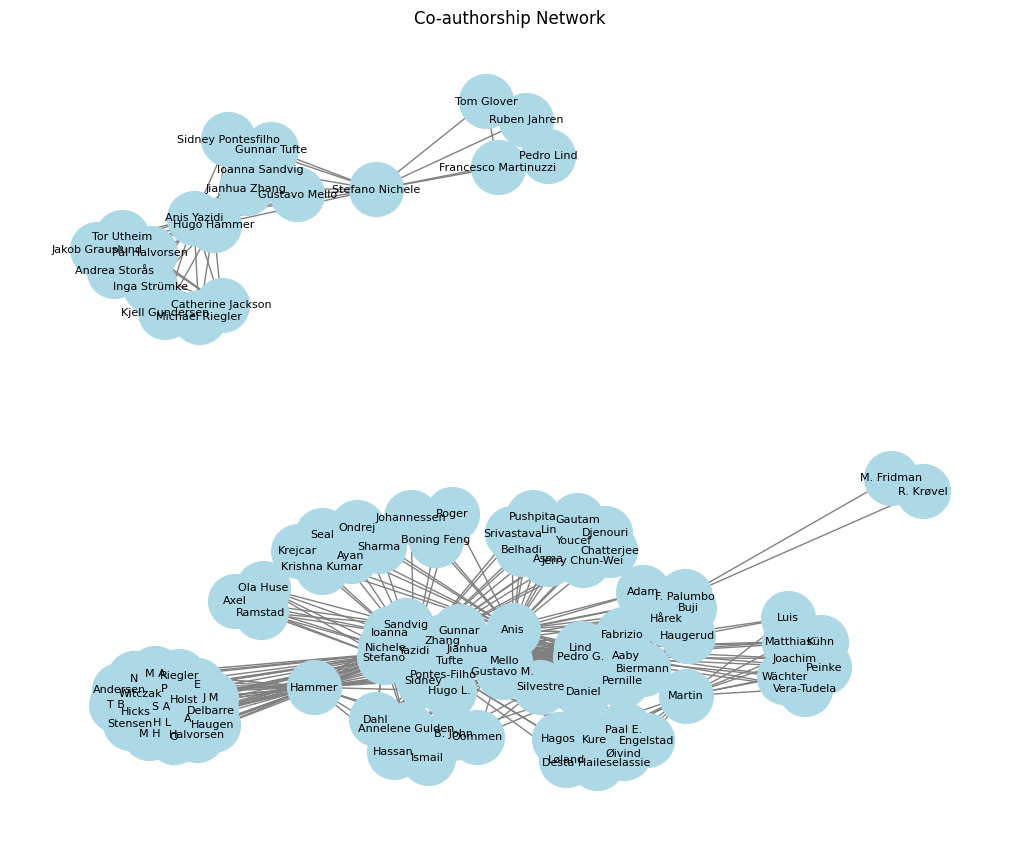

In [22]:
# create a co-authorship graph
G = nx.Graph()

for authors in df['authors_list']:
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):  # Avoid self-loops
            G.add_edge(authors[i], authors[j])

# visualize results
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.3)  
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=8)

plt.title("Co-authorship Network")
plt.show()

In [24]:
def clean_text(text):
    '''Cleans content column'''

    # remove journal homepage URLs
    text = re.sub(r'https?://\S+', '', text) 

    # remove ISSN numbers
    text = re.sub(r'ISSN:\s*\(.*?\)', '', text)

    # remove copyright/license info
    text = re.sub(r'©\s*\d{4}.*?license.*', '', text, flags=re.IGNORECASE)

    # remove unwanted "Downloaded from" lines or publication data
    text = re.sub(r'Downloaded from .+? on \w+ \d{2}, \d{4}', '', text)

    # remove any reference to URLs or links in text that aren’t essential
    text = re.sub(r'\bwww\.\S+', '', text) 

    # remove unwanted citations and references (vurder å fjerne dette)
    text = re.sub(r'REFERENCES AND NOTES.*', '', text, flags=re.DOTALL)  # remove references and notes section
    text = re.sub(r'\(\d+\)', '', text)  # remove inline citations 
    text = re.sub(r'\*\*P.*?Wilcoxon.*?\n', '', text)  # remove statistical results

    # normalize spaces and remove unwanted newlines
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [25]:
# apply cleaning
df["cleaned_content"] = df["content"].apply(clean_text)
df["cleaned_abstract"] = df["abstract"].apply(clean_text)

In [26]:
#pd.set_option('display.max_colwidth', None)
df[['cleaned_content']].head()

,cleaned_content
4,Advanced Passive Operating System Fingerprinti...
5,.................................................
6,EvoDynamic: a framework for the evolution of g...
7,A general representation of dynamical systems ...
9,"Accepted manuscript Aaby, P., Biermann, D., Ya..."


In [27]:
# save cleaned df to csv file
df.to_csv('df_cleaned.csv', index=False)